In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
from viz import plot_opinions_over_time, plot_campaign_budgets_with_order
from algos import compute_expected_value_for_budget_distribution, dynamic_programming_with_grid, forward_propagation_with_grid  
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [60]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix

def init_env(): 
    links = [
        (1, 3),
        (3, 2),
        
        (2, 3),
        (2, 0),
        (0, 2),
        
        (1, 2),
        (0, 1),
        
        # (3, 4),
        # (4, 3)
    ]

    num_nodes = 4
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0.7, 0, num_nodes)
    # initial_opinions = np.linspace(0, 1, num_nodes)
    # initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=100.0,
        desired_opinion=1.0,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

[0.7        0.46666667 0.23333333 0.        ]


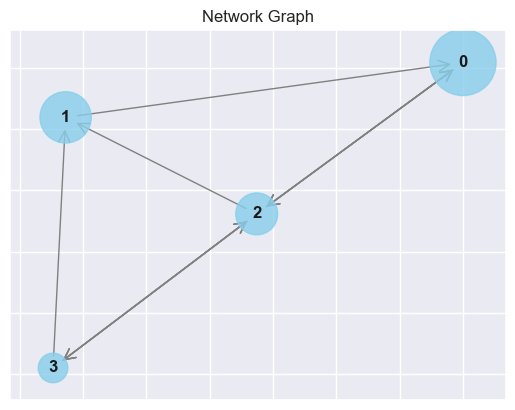

In [61]:
env = init_env()
print(env.opinions)
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


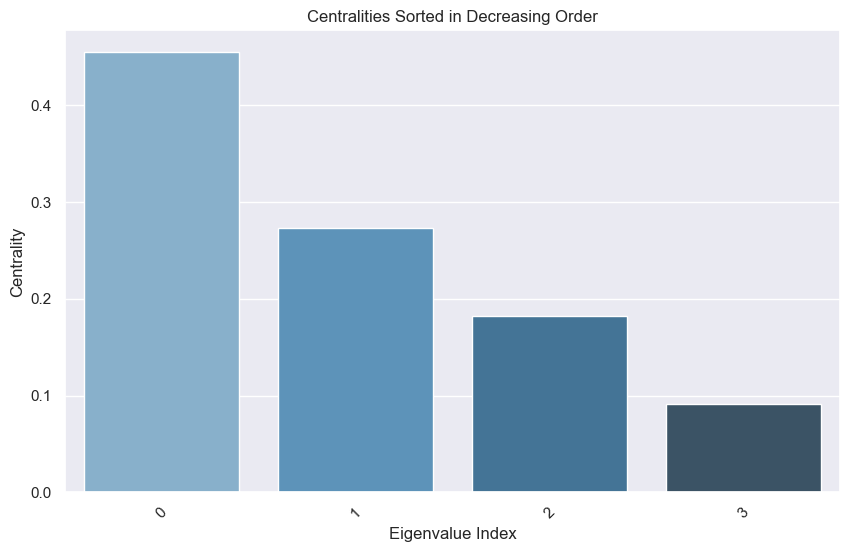

In [62]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.5204647904080085
Final Error: 0.5120701748735514


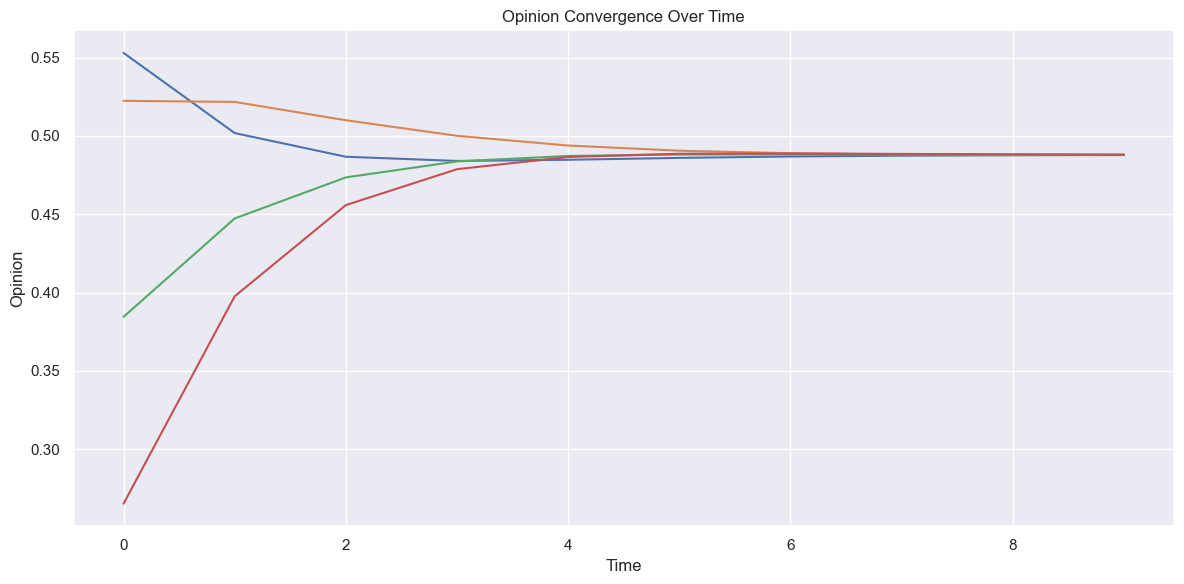

In [63]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

## Broadcast Strategy (use all available budget at start)

[0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.4404062183365226
Final Error: 0.4096100799532245


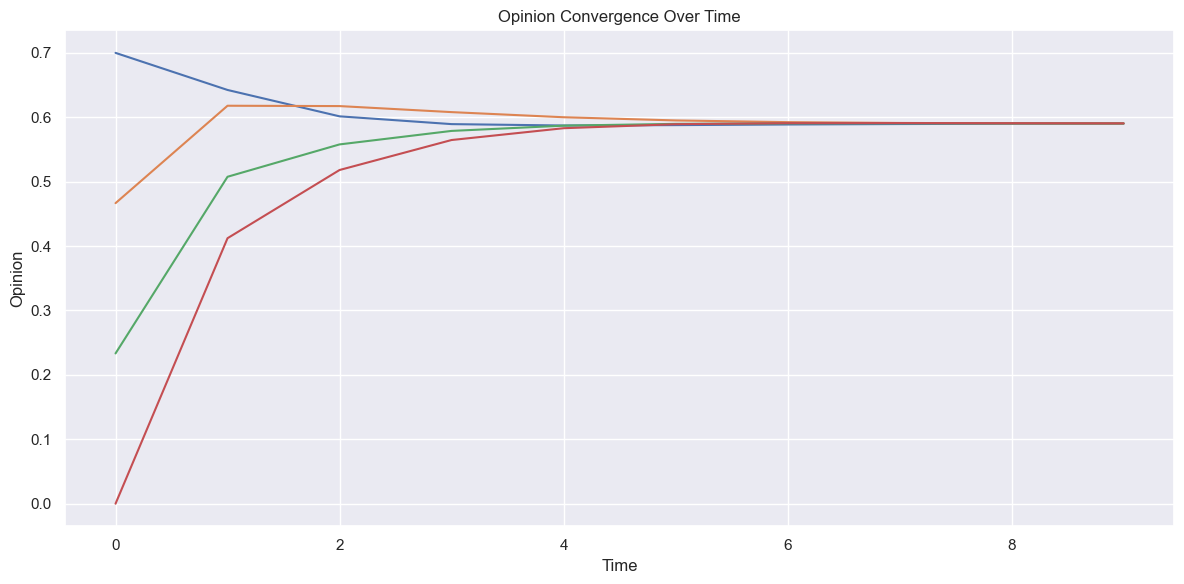

In [64]:
env = init_env()
num_steps = 10  # Total number of steps in the simulation
Q = 4  # Total budget

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast, budget_distribution, affected_nodes = (
    run_broadcast_strategy(env, Q, num_steps)
)
overall_error_broadcast = compute_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)
final_error_broadcast = compute_final_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)

### Correct DP

DPMULT step 1
Optimal Budget Allocation (BETA): [2 2]
Final Cost: 0.38894765840220413


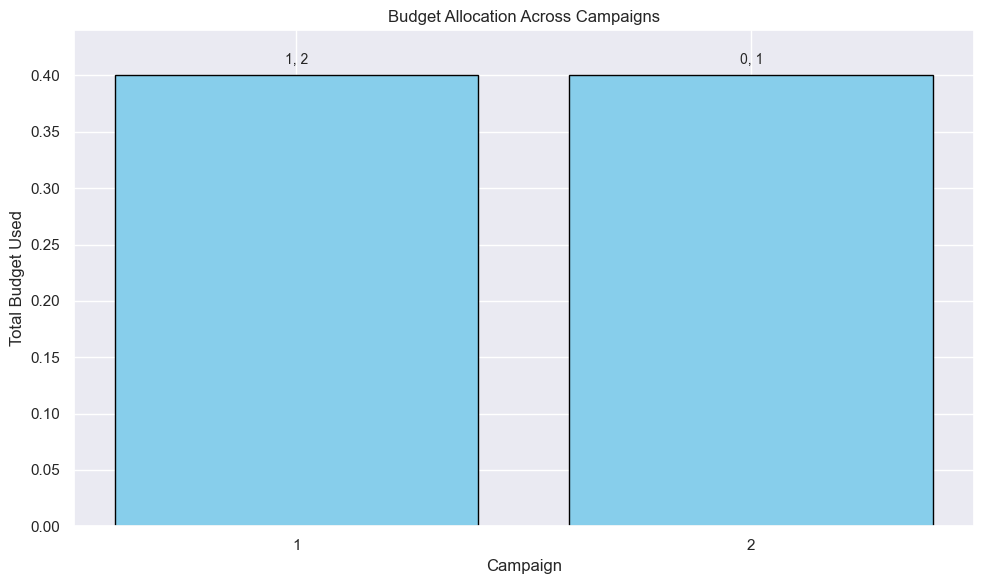

In [65]:
# Initialize environment
env = init_env()

# Parameters
M = 2  # Number of campaigns
TB = 4  # Total budget
ubar = env.max_u

# Run dynamic programming
V, B, order, order0 = dynamic_programming_multiplicative(env, M, TB)

# Forward propagation to compute optimal budget allocation and final cost
BETA, U, X, final_cost = forward_propagation_multiplicative(env, V, B, order, order0, M, TB)

# Print results
print("Optimal Budget Allocation (BETA):", BETA)
print("Final Cost:", final_cost)

plot_campaign_budgets_with_order(BETA, order, order0, ubar)

Dynamic Programming Strategy - Overall Error: 0.42578485812860584
Final Error: 0.3889476629653289
[array([1, 2], dtype=int64), array([0, 1], dtype=int64)]


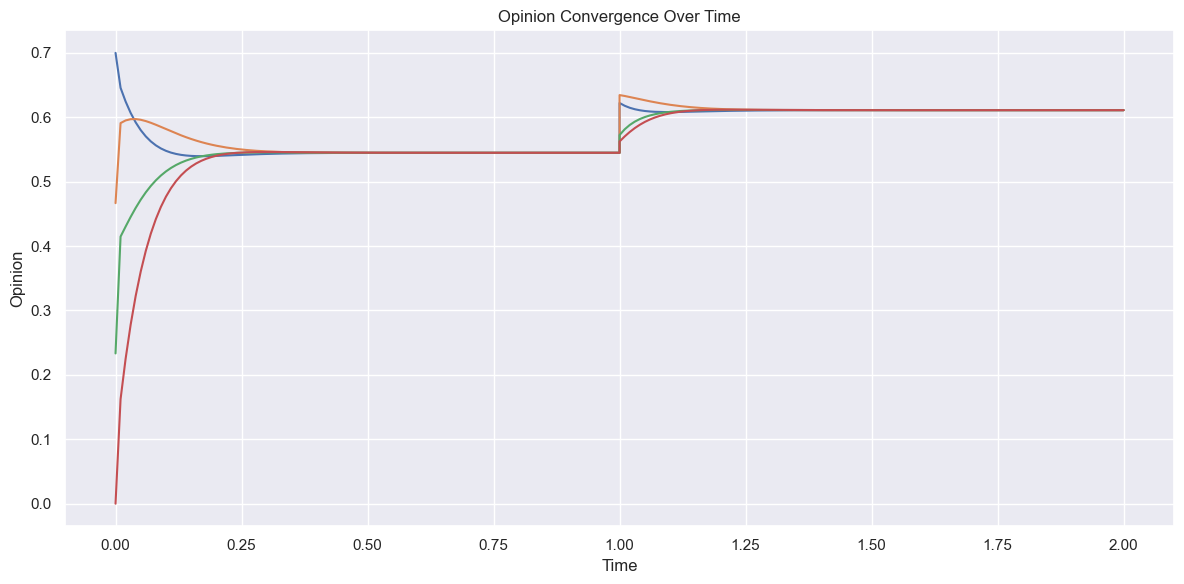

In [66]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
sampling_time = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

### Fine DP

In [75]:
import numpy as np
from itertools import combinations
from copy import deepcopy

def create_state_grid(N, nx):
    """Create a grid of states in the space [0, 1]^N."""
    grid_range = np.linspace(0, 1, nx)
    grids = [grid_range for _ in range(N)]
    return grids

def dynamic_programming_high_dim(env, M, TB, nx=10):
    env = deepcopy(env)
    N = env.num_agents
    ubar = env.max_u
    xd = env.desired_opinion

    grids = create_state_grid(N, nx)
    budget_levels = np.arange(TB + 1)  # Remaining budget levels from 0 to TB
    grid_shape = tuple(len(grid) for grid in grids) + (len(budget_levels),)

    V = np.full((M + 1,) + grid_shape, np.inf)
    B_dict = {}

    # Initialize terminal cost V[M] for all states and budget levels
    grid_points = np.array(np.meshgrid(*grids, indexing='ij')).reshape(N, -1).T
    terminal_cost = np.abs(grid_points - xd).mean(axis=1).reshape(tuple(len(grid) for grid in grids))

    for b_idx in range(len(budget_levels)):
        V[M, ..., b_idx] = terminal_cost

    # Dynamic Programming Backward Pass
    for k in range(M - 1, -1, -1):
        print(f"\nDP step {k}")
        for idx in np.ndindex(tuple(len(grid) for grid in grids)):
            current_states = np.array([grids[i][idx[i]] for i in range(N)])
            for rem_budget_idx, rem_budget in enumerate(budget_levels):
                val = np.inf
                best_control = None

                max_beta = min(rem_budget, N)  # Maximum number of agents we can control given the remaining budget

                # Iterate over all possible control actions within the budget constraint
                for beta_used in range(0, max_beta + 1):
                    for target_nodes in combinations(range(N), beta_used):
                        control_input = np.zeros(N)
                        for node in target_nodes:
                            control_input[node] = ubar

                        # Compute new opinions
                        new_states = env.compute_dynamics(current_states, control_input, step_duration=30)
                        new_states_clipped = np.clip(new_states, 0, 1)

                        # Map the next state to the closest grid indices
                        next_idx = tuple(np.abs(grids[i] - new_states_clipped[i]).argmin() for i in range(N))
                        next_rem_budget = rem_budget - beta_used
                        next_rem_budget_idx = next_rem_budget

                        future_cost = V[k + 1][next_idx + (next_rem_budget_idx,)]

                        # Immediate cost is zero except at the final stage
                        if k == M - 1:
                            immediate_cost = np.abs(new_states_clipped - xd).mean()
                        else:
                            immediate_cost = 0

                        total_cost = immediate_cost + future_cost

                        if total_cost < val:
                            val = total_cost
                            best_control = control_input
                            best_nodes = target_nodes

                if best_control is not None:
                    V[k][idx + (rem_budget_idx,)] = val
                    B_dict[(k,) + idx + (rem_budget_idx,)] = {'control': best_control, 'nodes': best_nodes}

    return V, B_dict

def forward_propagation_high_dim(env, V, B_dict, M, TB, nx=10):
    env = deepcopy(env)
    N = env.num_agents
    grids = create_state_grid(N, nx)
    X = np.zeros((N, M + 1))
    U = np.zeros((N, M))
    BETA_hd = np.zeros(M, dtype=int)
    X[:, 0] = env.opinions.copy()
    rem_budget = TB
    xd = env.desired_opinion
    ubar = env.max_u

    total_cost = 0

    for k in range(M):
        current_states = X[:, k]
        idx = tuple(np.abs(grids[i] - current_states[i]).argmin() for i in range(N))
        rem_budget_idx = rem_budget

        key = (k,) + idx + (rem_budget_idx,)
        control_data = B_dict.get(key, {'control': np.zeros(N), 'nodes': []})
        control_input, target_nodes = control_data['control'], control_data['nodes']
        U[:, k] = control_input

        # Apply control and compute next state
        new_states = env.compute_dynamics(current_states, control_input, step_duration=30)
        X[:, k + 1] = np.clip(new_states, 0, 1)

        beta_k = len(target_nodes)
        BETA_hd[k] = beta_k
        rem_budget -= beta_k

        # Immediate cost is zero except at the final stage
        if k == M - 1:
            immediate_cost = np.mean(np.abs(X[:, k + 1] - xd))
        else:
            immediate_cost = 0

        # Future cost
        if k < M - 1:
            next_idx = tuple(np.abs(grids[i] - X[:, k + 1][i]).argmin() for i in range(N))
            next_rem_budget_idx = rem_budget
            future_cost = V[k + 1][next_idx + (next_rem_budget_idx,)]
        else:
            future_cost = 0  # No future cost at final stage

        total_cost += immediate_cost + future_cost

        print(f"Stage {k} -> rem_budget={rem_budget}, beta_k={beta_k}, control_input={control_input}")
        print(f"  current_states={current_states}, new_states={X[:, k + 1]}")
        print(f"  immediate_cost={immediate_cost}, future_cost={future_cost}")
        print(f"  Total cost so far: {total_cost}")

        if rem_budget < 0 or beta_k > TB:
            print(f"Warning: Budget inconsistency detected at stage {k}. rem_budget={rem_budget}, beta_k={beta_k}")
            break

    final_cost = np.mean(np.abs((X[:, -1] - xd)))
    print(f"Final X: {X[:, -1]}")
    print(f"Final Cost from forward propagation: {final_cost}")
    print(f"Total Expected Cost (from V and propagation): {total_cost}")
    return X, U, BETA_hd, final_cost

# Example usage:
# Initialize environment
env = init_env()
M = 2  # Number of stages
TB = 4  # Total budget
nx = 10  # Number of grid points per agent

# Run dynamic programming
V, B_dict = dynamic_programming_high_dim(env, M, TB, nx=nx)

# Run forward propagation to evaluate the policy
X, U, BETA_hd, final_cost = forward_propagation_high_dim(env, V, B_dict, M, TB, nx=nx)

# Output the final results
print()
print("Optimal Budget Allocation (BETA_hd):", BETA_hd)
print("Final Cost:", final_cost)



DP step 1

DP step 0
Stage 0 -> rem_budget=2, beta_k=2, control_input=[0.2 0.2 0.  0. ]
  current_states=[0.7        0.46666667 0.23333333 0.        ], new_states=[0.54424242 0.54424242 0.54424242 0.54424242]
  immediate_cost=0, future_cost=0.7131313131313102
  Total cost so far: 0.7131313131313102
Stage 1 -> rem_budget=0, beta_k=2, control_input=[0.2 0.2 0.  0. ]
  current_states=[0.54424242 0.54424242 0.54424242 0.54424242], new_states=[0.61053444 0.61053444 0.61053444 0.61053444]
  immediate_cost=0.38946556473828675, future_cost=0
  Total cost so far: 1.102596877869597
Final X: [0.61053444 0.61053444 0.61053444 0.61053444]
Final Cost from forward propagation: 0.38946556473828675
Total Expected Cost (from V and propagation): 1.102596877869597

Optimal Budget Allocation (BETA_hd): [2 2]
Final Cost: 0.38946556473828675


In [68]:
import numpy as np
from itertools import combinations

def rank_combinations_by_value(env, V, M, TB, nx=10, target_budget=(2, 2), gamma=1):
    """
    Prints and ranks combinations for each stage based on a specified budget allocation.

    Args:
        env: The environment with network properties.
        V: Value function array from dynamic programming.
        M: Number of campaigns.
        TB: Total budget.
        nx: Number of grid points per agent.
        target_budget: Tuple representing the budget allocation for each stage.
        gamma: Discount factor.

    Returns:
        List of combinations ranked by total cost for each stage.
    """
    N = env.num_agents
    ubar = env.max_u
    xd = env.desired_opinion
    grids = create_state_grid(N, nx)

    # Use the current state of opinions in the environment as the starting point
    current_states = env.opinions.copy()
    all_ranked_combinations = []

    for k, budget in enumerate(target_budget):
        print(f"\nEvaluating all combinations for stage {k} with budget {budget}:")

        ranked_combinations = []
        for target_nodes in combinations(range(N), budget):
            # Set control input for selected nodes
            control_input = np.zeros(N)
            for node in target_nodes:
                control_input[node] = ubar

            # Compute the new states using the environment's dynamics
            new_states = env.compute_dynamics(current_states, control_input, step_duration=1)
            new_states_clipped = np.clip(new_states, 0, 1)

            # Find the grid index for the resulting new state
            next_idx = tuple(np.searchsorted(grids[i], new_states_clipped[i]) - 1 for i in range(N))
            next_idx = tuple(np.clip(next_idx[i], 0, nx - 1) for i in range(N))

            # Immediate cost based on the mean absolute difference
            immediate_cost = np.abs(new_states_clipped - xd).mean()

            # Future cost calculation for remaining budget
            remaining_budget = TB - sum(target_budget[:k + 1])  # Ensure remaining budget is accurate
            if k + 1 < M:
                future_cost = V[k + 1][next_idx + (remaining_budget,)]
            else:
                future_cost = 0  # No future cost at the last stage

            # Calculate the total cost for this combination
            total_cost = immediate_cost + gamma * future_cost

            # Save each combination and its cost
            ranked_combinations.append((target_nodes, total_cost))

        # Sort and display combinations by total cost for the current stage
        ranked_combinations.sort(key=lambda x: x[1])
        all_ranked_combinations.append(ranked_combinations)

        print(f"\nRanked combinations by total cost for stage {k}:")
        for nodes, cost in ranked_combinations:
            print(f"  Nodes: {nodes}, Total Cost: {cost:.4f}")

    return all_ranked_combinations

# Example usage
target_budget = (2, 2)  # Example budget allocation for stages
ranked_combinations = rank_combinations_by_value(env, V, M, TB, nx=nx, target_budget=target_budget, gamma=0.9)



Evaluating all combinations for stage 0 with budget 2:

Ranked combinations by total cost for stage 0:
  Nodes: (1, 2), Total Cost: 1.3282
  Nodes: (0, 1), Total Cost: 1.3307
  Nodes: (1, 3), Total Cost: 1.3322
  Nodes: (2, 3), Total Cost: 1.3384
  Nodes: (0, 2), Total Cost: 1.3779
  Nodes: (0, 3), Total Cost: 1.3818

Evaluating all combinations for stage 1 with budget 2:

Ranked combinations by total cost for stage 1:
  Nodes: (1, 2), Total Cost: 0.4732
  Nodes: (0, 1), Total Cost: 0.4757
  Nodes: (1, 3), Total Cost: 0.4772
  Nodes: (0, 2), Total Cost: 0.4820
  Nodes: (2, 3), Total Cost: 0.4834
  Nodes: (0, 3), Total Cost: 0.4859


In [69]:
target_budget = (3, 1)  # Example budget allocation for stages
ranked_combinations = rank_combinations_by_value(env, V, M, TB, nx=nx, target_budget=target_budget, gamma=0.9)



Evaluating all combinations for stage 0 with budget 3:

Ranked combinations by total cost for stage 0:
  Nodes: (1, 2, 3), Total Cost: 1.3096
  Nodes: (0, 1, 2), Total Cost: 1.3286
  Nodes: (0, 1, 3), Total Cost: 1.3325
  Nodes: (0, 2, 3), Total Cost: 1.3388

Evaluating all combinations for stage 1 with budget 1:

Ranked combinations by total cost for stage 1:
  Nodes: (1,), Total Cost: 0.4999
  Nodes: (2,), Total Cost: 0.5062
  Nodes: (0,), Total Cost: 0.5087
  Nodes: (3,), Total Cost: 0.5101


In [70]:
final_opinion_error, total_cost, costs, X = (
    compute_expected_value_for_budget_distribution(
        BETA_hd, env, M, step_duration
    )
)


final_opinion_error

0.4096969696969732

Dynamic Programming Strategy - Overall Error: 0.464488065404953
Final Error: 0.4096969696969753
[array([], dtype=int64), array([0, 1, 2, 3], dtype=int64)]


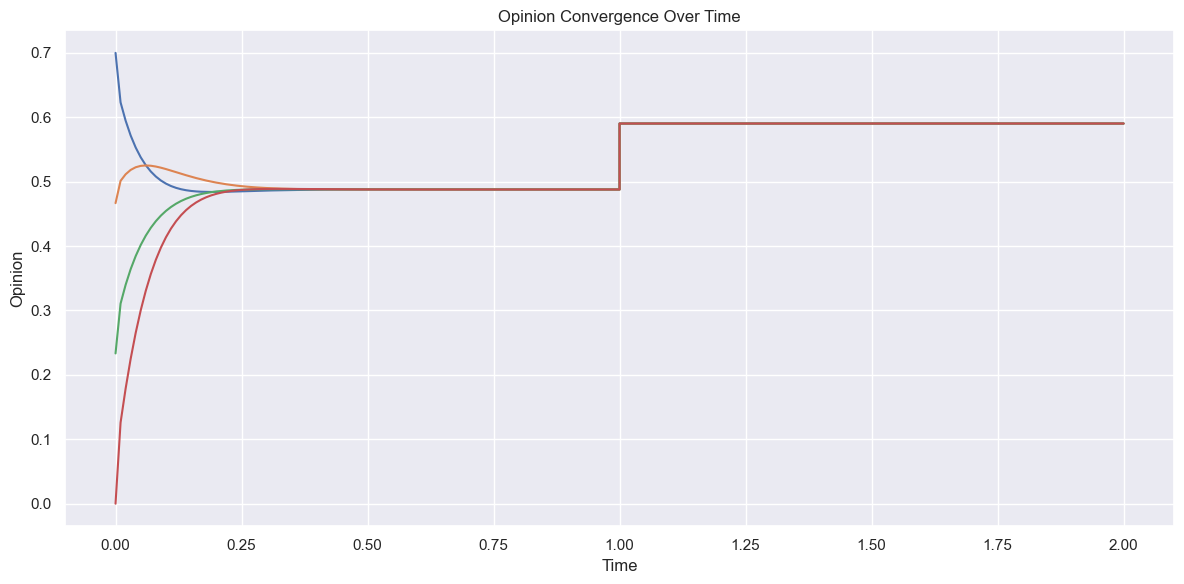

In [71]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
sampling_time = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA_hd,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

In [72]:
### Brute force search

from itertools import product
from algos import run_dynamic_programming_campaigns, compute_average_error, compute_final_average_error
from viz import plot_opinions_over_time
from tqdm import tqdm

# Define parameters
total_budget = 4
num_campaigns = 2  # Number of campaigns
step_duration = 10
final_campaign_step_duration = 10  # Longer duration for the final campaign
sampling_time = 0.1
final_campaign_sampling_time = 0.1

# Initialize environment
env = init_env()

# Function to generate all valid budget allocations
def generate_valid_budget_allocations(total_budget, num_campaigns):
    """Generate all budget combinations where the sum of budgets is <= total_budget."""
    allocations = []
    for allocation in product(range(total_budget + 1), repeat=num_campaigns):
        if sum(allocation) <= total_budget:
            allocations.append(allocation)
    return allocations

# Get all valid budget allocations
valid_budget_allocations = generate_valid_budget_allocations(total_budget, num_campaigns)

# Store all results: budget combination and corresponding final error
results = []

# Brute-force search over all budget allocations
for budget_allocation in tqdm(valid_budget_allocations, desc="Running Campaigns"):
    # Reset environment for each test
    env = init_env()

    # Run the campaigns using the current budget allocation
    opinions_over_time, time_points, nodes_controlled_simulation = run_dynamic_programming_campaigns(
        env,
        budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )

    # Compute final error
    final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

    # Store the result as a tuple of (budget_allocation, final_error)
    results.append((budget_allocation, final_error))

# Sort results by final error (ascending)
results_sorted_by_error = sorted(results, key=lambda x: x[1])

# Function to display top N budget combinations
def show_top_n_budget_combinations(results_sorted, top_n=5):
    print(f"Top {top_n} Budget Combinations by Final Error:")
    for i in range(min(top_n, len(results_sorted))):
        budget_allocation, final_error = results_sorted[i]
        print(f"Rank {i+1}: Budget: {budget_allocation}, Final Error: {final_error}")

# Display the top N budget combinations
show_top_n_budget_combinations(results_sorted_by_error, top_n=5)

Running Campaigns: 100%|██████████| 15/15 [00:00<00:00, 74.14it/s]

Top 5 Budget Combinations by Final Error:
Rank 1: Budget: (2, 2), Final Error: 0.3889476629653289
Rank 2: Budget: (3, 1), Final Error: 0.38898072042628284
Rank 3: Budget: (1, 3), Final Error: 0.3952066147903484
Rank 4: Budget: (0, 4), Final Error: 0.4096969696969753
Rank 5: Budget: (4, 0), Final Error: 0.4096969696969758


In [73]:
# results_sorted_by_error